# 5. Evaluate the GWL modeling map

This notebook evaluates the the result of the GWL modeling maps produced with the notebook 5. estimage_gee.ipynb. <br>
The evaluation is done by comparing the GWL modeling average values of the maps (time series) within a given PHU with the average values of the GWL measurements within the same PHU. <br>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ee
from sepal_ui.mapping import SepalMap
from gee_scripts.gee import reduce_to, get_footprint, reduce_df_by
import gee_scripts.parameters as params
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


<IPython.core.display.Javascript object>

ResizeTrigger()

Earth Engine initialized successfully, with ee-dfgm2006


## 5.1. Visualizae data

In [3]:
 # Set up the input parameters

# Set the image collection
image_collection_id = "projects/ee-marortpab/assets/gwl-modeling/estimation/best_models/RandomForest_kalimantan_phu_model_350_351_357_379_Pablo_no_bad_stations_trees_250"

# image_collection_id = "projects/ee-indonesia-gwl/assets/gwl-modeling/estimation/best_models/RandomForest_kalimantan_phu_model_350_351_357_379_Pablo_no_bad_stations_trees_250"

training_data = ee.FeatureCollection("projects/ee-indonesia-gwl/assets/all_training_data_with_extra_and_locations_and_precipSum")

# Define the asset id for the phus
phus_asset_id = "projects/ee-indonesia-gwl/assets/all_phus_numbered"


df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])

In [4]:
ee_modeled_ic = ee.ImageCollection(image_collection_id)
ee_phus = ee.FeatureCollection(phus_asset_id)
ee_model_phu_sources = ee_phus.filter(ee.Filter.inList("phu_id", ee.List([350,351,357,379])))

In [5]:
ee_footprints_fc = ee.FeatureCollection(ee_modeled_ic.map(get_footprint).toList(ee_modeled_ic.size()))

## 5.2. Select the target PHU

We can only evaluate the model where we have GWL measurements. <br>
The map below show the following layers:
- The PHU boundaries (red)
- The PHU which where used to train the GWL model (black)
- The GWL field measurements (white)
- The GWL modeling boundaries: the footprint of the GWL modeling map (blue)

By using the inspector tool, we can select a PHU where we have already an estimated GWL TS (blue) and the GWL measurements (white).

In [6]:
map_ = SepalMap(vinspector=True, basemaps=["SATELLITE"])
map_.centerObject(ee_footprints_fc)
map_.addLayer(ee_phus, {"color": "red"}, "all phus")
map_.addLayer(ee_model_phu_sources, {"color": "black"}, "phus used to train the model")
map_.addLayer(training_data, {"color": "white"}, "training data")
map_.addLayer(ee_footprints_fc, {"color": "blue"}, "estimated footprints")
map_

SepalMap(center=[0, 0], controls=(ZoomControl(options=['position', 'transparent_bg'], position='topright', wid…

## 5.3. Evaluate the GWL modeling map

In [7]:
# Set the parameters for the reduction
reduce_by = "mean"

### 5.3.1. Calculate the [mean, std or median] of the GWL modeling map within the selected PHU

In [9]:
target_phu_id = 119
target_phu = ee_phus.filter(ee.Filter.eq("phu_id", target_phu_id)).first().geometry()

In [10]:
# Filter the collection to only show the images that intersect with the target phu
ee_ic_filtered = ee_modeled_ic.filter(ee.Filter.bounds(target_phu.centroid()))
ee_filtered_footprints_fc = ee.FeatureCollection(ee_ic_filtered.map(get_footprint
    ).toList(ee_modeled_ic.size())
)

In [11]:
# Add the target phu to the map
map_.addLayer(ee_filtered_footprints_fc, {"color": "purple"}, "target phu")

In [12]:
# Extract the mean values 
# The line below will calculate the [mean, std, median] of the modeled time series for the target phu
# this process might take a while
model_ts_features = ee_ic_filtered.map(lambda image: reduce_to(image, target_phu, reduce_by)).getInfo()

# print the number of images in the collection
print(len(model_ts_features["features"]))

243


In [13]:
# Convert the list of features to a pandas DataFrame.
model_ts_data = [feature["properties"] for feature in model_ts_features["features"]]

reduced_model_df = pd.DataFrame(model_ts_data)
reduced_model_df['date'] = pd.to_datetime(reduced_model_df['date'])
reduced_model_df = reduced_model_df.sort_values('date')
reduced_model_df = reduced_model_df.dropna()
reduced_model_df = reduced_model_df.set_index('date')

print(len(reduced_model_df))
reduced_model_df.head()

243


,reduced_value
date,
2019-06-05,14.946729
2019-06-06,15.803554
2019-06-10,-14.232023
2019-06-11,-5.276677
2019-06-17,6.135789


### 5.3.2. Calculate the [mean, std or median] of the field GWL measurements within the selected PHU

In [14]:
# Subset the mean values from the field data for all the stations within the target phu

reduced_field_df = reduce_df_by(
    grouped_df = df[(df.phu_id==target_phu_id) & (df.gwl_cm>-200) ].groupby(["date"])["gwl_cm"],
    reduce_by = reduce_by
)

# rename the column
reduced_field_df = reduced_field_df.reset_index()

# Set the date as the index
reduced_field_df = reduced_field_df.set_index("date")

reduced_field_df.head()

,gwl_cm
date,
2018-10-20,-25.5
2018-10-26,-34.7
2018-11-01,-22.2
2018-11-07,-29.5
2018-11-13,-34.6


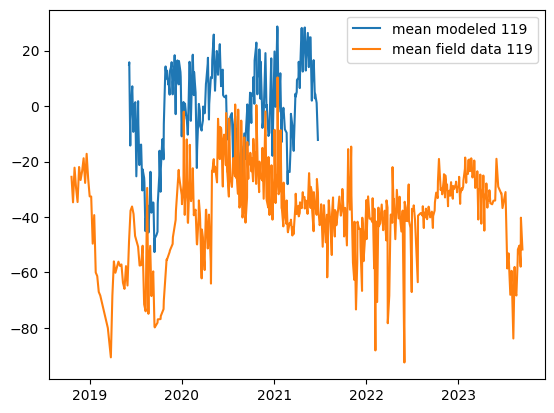

In [15]:
# plot mean_estimation and mean_field_data

plt.plot(reduced_model_df.index, reduced_model_df['reduced_value'], label=f"{reduce_by} modeled {target_phu_id}")
plt.plot(reduced_field_df.index, reduced_field_df.gwl_cm, label=f"{reduce_by} field data {target_phu_id}")
plt.legend()
plt.show()

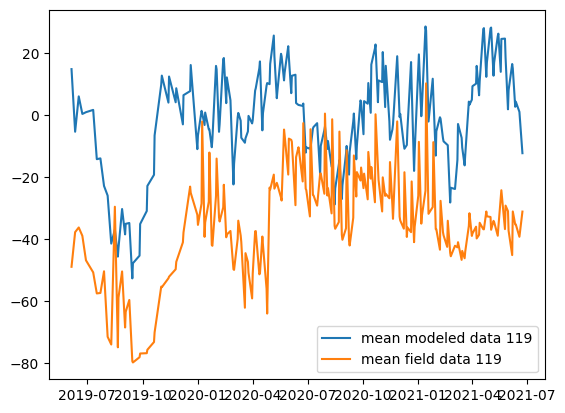

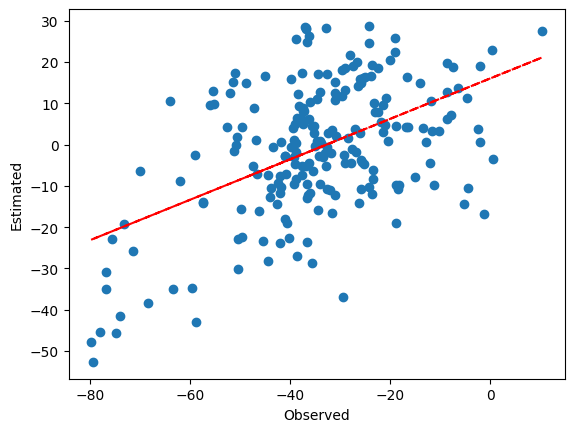

In [18]:
# plot observed vs estimated where dates match

reduced_field_df = reduced_field_df[reduced_field_df.index.isin(reduced_model_df.index)]
reduced_field_df = reduced_field_df.sort_index()

plt.plot(reduced_field_df.index, reduced_model_df.loc[reduced_field_df.index, 'reduced_value'], label=f"{reduce_by} modeled data {target_phu_id}")
plt.plot(reduced_field_df.index, reduced_field_df['gwl_cm'], label=f"{reduce_by} field data {target_phu_id}")
plt.legend()
plt.show()

# observed vs estimated scatter plot

plt.scatter(reduced_field_df['gwl_cm'], reduced_model_df.loc[reduced_field_df.index, 'reduced_value'])

# Add a trendline
z = np.polyfit(reduced_field_df['gwl_cm'], reduced_model_df.loc[reduced_field_df.index, 'reduced_value'], 1)
p = np.poly1d(z)
plt.plot(reduced_field_df['gwl_cm'],p(reduced_field_df['gwl_cm']),"r--")

plt.xlabel("Observed")
plt.ylabel("Estimated")
plt.show()